# Metro Gold Line (804)

### Below we examine approximately 10 hours of data logged from the Metro Gold Line

In [67]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone

tracking_data = pd.read_csv('sample_tracking_data.csv')
tracking_data.drop('id', axis=1, inplace=True)# TODO: remove this from logging

def utc_to_pst(timestamp): # maybe this func should be applied in the logging script
    time = datetime.fromtimestamp(timestamp)
    time = time.replace(tzinfo=timezone('UTC'))
    time = time.astimezone(timezone('America/Los_Angeles'))
    return time.strftime("%m/%d/%y, %I:%M:%S%P %Z")

tracking_data['time'] = tracking_data.apply(lambda row: utc_to_pst(row.timestamp), axis=1)
    

In [68]:
tracking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 7 columns):
timestamp     1702 non-null int64
vehicle_id    1702 non-null int64
route_id      1702 non-null int64
lat           1702 non-null float64
lon           1702 non-null float64
direction     1702 non-null float64
time          1702 non-null object
dtypes: float64(3), int64(3), object(1)
memory usage: 93.2+ KB


In [79]:
tracking_data.head()

,timestamp,vehicle_id,route_id,lat,lon,direction,time
0,2018-08-25 16:57:41,406,804,34.116257,-118.156545,0.0,"08/25/18, 04:57:41P PDT"
1,2018-08-25 16:57:01,401,804,34.088014,-118.212430,180.0,"08/25/18, 04:57:01P PDT"
2,2018-08-25 16:57:41,411,804,34.047772,-118.227849,180.0,"08/25/18, 04:57:41P PDT"
3,2018-08-25 16:57:29,407,804,34.070755,-118.228575,0.0,"08/25/18, 04:57:29P PDT"
4,2018-08-25 16:56:27,413,804,34.133057,-118.003055,0.0,"08/25/18, 04:56:27P PDT"


In [70]:
tracking_data.direction.value_counts()

0.0      904
180.0    798
Name: direction, dtype: int64

In [71]:
tracking_data.timestamp = pd.to_datetime(tracking_data.time) - timedelta(hours=7)

In [95]:
tracking_data.query('vehicle_id==406').assign(delta = lambda df: df.timestamp.diff().map(lambda x: x.total_seconds())).plot('timestamp', 'delta', color='direction')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10fc94f28> (for post_execute):


ValueError: Invalid RGBA argument: 'direction'

ValueError: Invalid RGBA argument: 'direction'

<Figure size 432x288 with 1 Axes>

In [58]:
import seaborn as sns
%matplotlib inline

In [80]:
df = tracking_data.query('vehicle_id==406')

In [84]:
df.timestamp.diff().describe()

count                        62
mean     0 days 00:02:59.983870
std      0 days 00:00:53.333313
min             0 days 00:00:00
25%      0 days 00:02:50.500000
50%             0 days 00:03:00
75%      0 days 00:03:05.750000
max             0 days 00:07:38
Name: timestamp, dtype: object

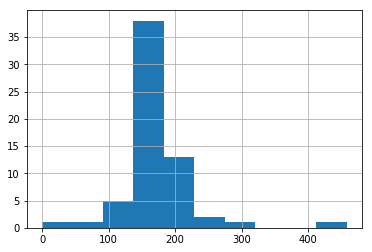

In [92]:
df.timestamp.diff().map(lambda x: x.total_seconds()).hist()

## Identify Duplicates

The Metro API 'vehicles' endpoint for rail line 804 was polled every 3 minutes for 10 hours. Since GPS positions frequently take over 3 minutes to update (sometimes more, sometimes less), then we need to remove all duplicate entries in the data.

In [2]:
def get_dups_on(dataframe, subset):
    return dataframe[dataframe.duplicated(subset=subset)]

def show_all_dups(vehicle_id, df):
    print('VEHICLE: ' + str(vehicle_id))
    dups = get_dups_on(df, ['timestamp', 'lat', 'lon'])
    print(dups[['time', 'lat', 'lon']])

def select_rows_by_value(df, col, val):
    return df[df[col] == val]

for vehicle_id in tracking_data.vehicle_id.unique():
    vehicle = select_rows_by_value(tracking_data, 'vehicle_id', vehicle_id)
    show_all_dups(vehicle_id, vehicle)
    print()

position_log = tracking_data.drop_duplicates(subset=['timestamp', 'lat', 'lon', 'vehicle_id'])

VEHICLE: 406
                        time        lat         lon
142  08/25/18, 05:29:06P PDT  34.136919 -117.891003

VEHICLE: 401
Empty DataFrame
Columns: [time, lat, lon]
Index: []

VEHICLE: 411
Empty DataFrame
Columns: [time, lat, lon]
Index: []

VEHICLE: 407
                         time        lat         lon
203   08/25/18, 05:44:20P PDT  34.136919 -117.891003
1028  08/25/18, 09:35:36P PDT  34.033395 -118.154466

VEHICLE: 413
                         time        lat         lon
356   08/25/18, 06:23:43P PDT  34.033395 -118.154466
1318  08/25/18, 11:40:54P PDT  34.033395 -118.154466

VEHICLE: 404
                        time        lat         lon
300  08/25/18, 06:08:28P PDT  34.033395 -118.154466
894  08/25/18, 08:47:10P PDT  34.033395 -118.154466

VEHICLE: 412
Empty DataFrame
Columns: [time, lat, lon]
Index: []

VEHICLE: 402
                        time        lat         lon
161  08/25/18, 05:32:22P PDT  34.033395 -118.154466
489  08/25/18, 06:57:36P PDT  34.136919 -117.891003

## Geographic Distribution of GPS updates

This map shows the locations where GPS updates were recorded. The number of locations is less (by a lot) than the number of GPS polls, which strongly supports the theory that GPS positions are triggered as trains pass certain sections of track and are not on the trains themselves.

In [108]:
from collections import defaultdict

In [112]:
a = defaultdict(int)

In [113]:
a[(1,1)] +=1

In [117]:
stops = tracking_data[['lat', 'lon']]

In [125]:
import folium
stops = tracking_data[['lat', 'lon']]

#print(transmitters)
#print('Number of GPS transmitter locations: ' + str(len(transmitters)))

map = folium.Map()

station_marker = folium.Icon(color='red', icon='fa-dot-circle')

locations = defaultdict(int)

for _,row in stops.iterrows():
    label = (row.lat, row.lon)
    locations[label] +=1
    
for point, count in locations.items():
    marker = folium.Marker(location=point, popup=f'{count}')
    marker.add_to(map)
    
#for index, row in stops.iterrows():
#    coords = [row.stop_lat, row.stop_lon]
#    name = row.stop_name
#    marker = folium.Marker(location=coords, popup=name, icon=folium.Icon(color='red'))
#    marker.add_to(map)

map.fit_bounds([[33.907635, -118.480682], [34.169517, -118.019256]])
map

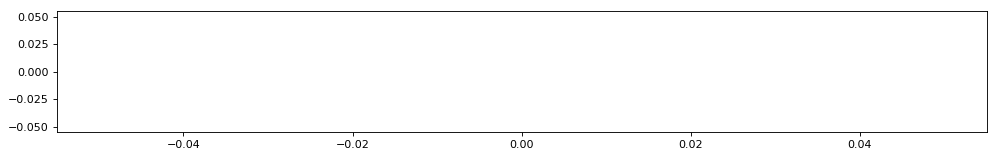

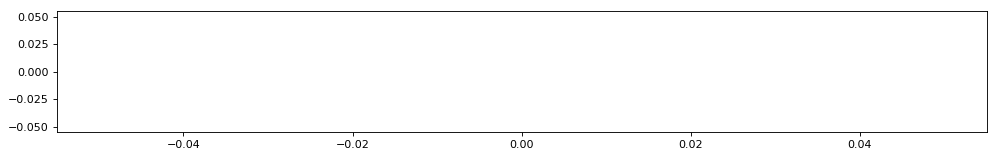

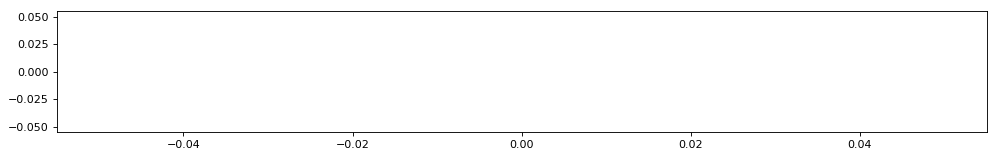

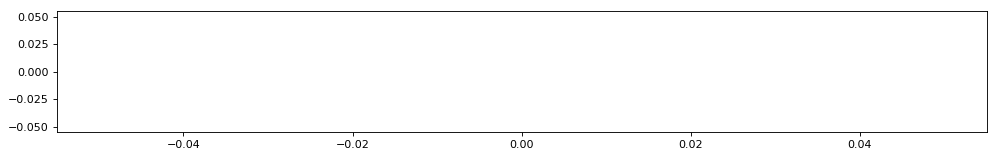

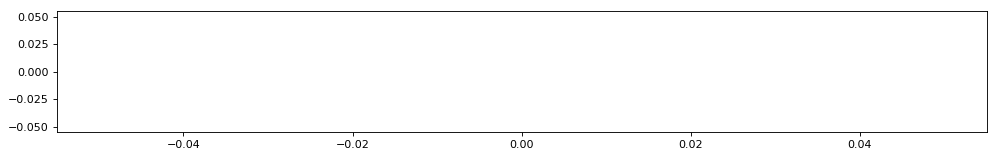

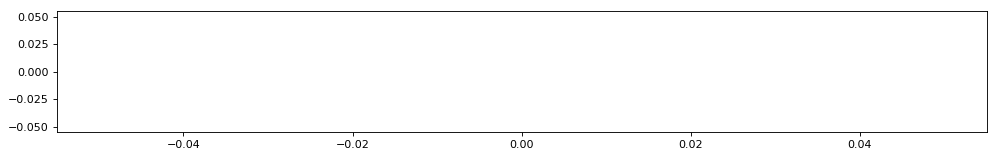

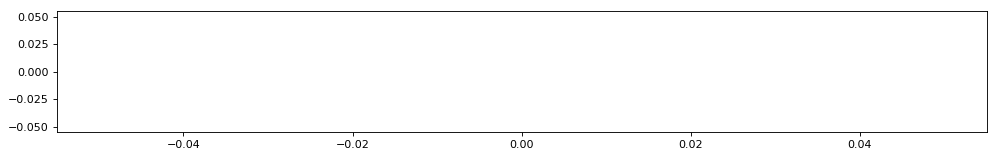

In [68]:
import matplotlib.pyplot as plt

for i in range(7):
    vehicle = 213 + i
    vehicleInfo = tracking_data.loc[tracking_data['vehicle_id'] == vehicle]
    plt.figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')

    ar = vehicleInfo.timestamp
    plt.plot(ar, len(ar) * [1], 'x')
    plt.show()

    # This plot shows the distribution of GPS updates over time for each train. 
    # We need to do this with a larger sample size to understand whether or not GPS updates are regular
    # Perhaps somebody could calculate the average and std dev of time between GPS updates for all trains

In [ ]:
import folium
train_map = folium.Map()
vehicles = []
for train in trains.id:
    vehicles.append({'loc': [trains.lat[train - 1], trains.lon[train - 1]], 'label': 'Train'})
    
for point in vehicles:
    marker = folium.Marker(location=point['loc'], popup=point['label'])
    marker.add_to(train_map)

train_map

In [ ]:
import pandas as pd
#stops = pd.read_csv('stops.txt')
stop_times = pd.read_csv('stop_times.csv')
stop_ids = stop_times.stop_id.tolist()

line_ids = list(map(lambda x: str(x)[0:3], stop_ids))
station_ids = list(map(lambda x: str(x)[3:5], stop_ids))

line_id = pd.DataFrame({"line_id": line_ids})
station_id = pd.DataFrame({"station_id": station_ids})

df = pd.concat([stop_times, line_id], axis=1)
df = pd.concat([df, station_id], axis=1)
print(df[['trip_id', 'arrival_time', 'stop_id', 'line_id', 'station_id']].head())
    

In [ ]:
stops = pd.read_csv('stops.txt')
#print(stops[['stop_id', 'stop_lat', 'stop_lon']].head())
df['stop_id'] = df['stop_id'].apply(str)
merged = df.merge(stops, how = 'inner', on = 'stop_id')
print(merged[['line_id', 'station_id', 'arrival_time', 'stop_lat', 'stop_lon']][0:100])

# This collects latitudes and longitudes of every point along the train schedule

In [ ]:
print(stops.loc[stops['stop_name'] == 'Little Tokyo / Arts District Station'])